In [29]:
# TECH CHALLENGE - FASE 2
# Previsão se o IBOVESPA vai subir ou cair no próximo dia

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import joblib
import yfinance as yf

# 1. Baixando os dados do IBOVESPA
ticker = "^BVSP"
inicio = "2019-01-01"
fim = "2025-10-24"

print("Baixando dados do IBOVESPA...")
df_raw = yf.download(ticker, start=inicio, end=fim)

# Às vezes o yfinance traz colunas duplicadas, serve para evitar erros
if isinstance(df_raw.columns, pd.MultiIndex):
    df_raw.columns = df_raw.columns.get_level_values(0)

# Renomeando as colunas
df = df_raw.rename(columns={
    "Close": "Ultimo",
    "Open": "Abertura",
    "High": "Maxima",
    "Low": "Minima",
    "Volume": "Vol"
}).reset_index()

df["Data"] = pd.to_datetime(df["Date"])
df.drop(columns=["Date"], inplace=True)

print(f"Período disponível: {df['Data'].min().date()} até {df['Data'].max().date()}")
print("Total de linhas:", df.shape[0])

# 2. Criando a coluna que indica se o próximo dia subiu (1) ou caiu (0)
df["Ultimo_amanha"] = df["Ultimo"].shift(-1)
df["target"] = (df["Ultimo_amanha"] > df["Ultimo"]).astype(int)
df.dropna(inplace=True)

# Mostra um exemplo de tendência
exemplo = df.tail(5).copy()
exemplo["Tendência"] = exemplo["target"].map({1: "↑", 0: "↓"})
exemplo.rename(columns={"Ultimo": "Fechamento"}, inplace=True)
print("\nExemplo de tendência recente:")
print(exemplo[["Data", "Fechamento", "Tendência"]].to_string(index=False))

# 3. Criando algumas funções de indicadores (RSI, MACD, Bandas de Bollinger)
def RSI(serie, periodo=14):
    delta = serie.diff()
    ganho = delta.clip(lower=0)
    perda = -delta.clip(upper=0)
    media_ganho = ganho.rolling(periodo).mean()
    media_perda = perda.rolling(periodo).mean()
    rs = media_ganho / (media_perda + 1e-9)
    return 100 - (100 / (1 + rs))

def MACD(serie):
    ema_curta = serie.ewm(span=12, adjust=False).mean()
    ema_longa = serie.ewm(span=26, adjust=False).mean()
    macd = ema_curta - ema_longa
    sinal = macd.ewm(span=9, adjust=False).mean()
    hist = macd - sinal
    return macd, sinal, hist

def bollinger(series, janela=20, std=2):
    media = series.rolling(janela).mean()
    desvio = series.rolling(janela).std()
    sup = media + std * desvio
    inf = media - std * desvio
    return sup, inf

# 4. Criando as variáveis (features) que o modelo vai usar
df["pct_change"] = df["Ultimo"].pct_change().fillna(0)
df["ma5"] = df["Ultimo"].rolling(5).mean().bfill()
df["ma10"] = df["Ultimo"].rolling(10).mean().bfill()
df["ma20"] = df["Ultimo"].rolling(20).mean().bfill()

for i in range(1, 6):
    df[f"lag_{i}"] = df["Ultimo"].shift(i).bfill()

df["rsi14"] = RSI(df["Ultimo"]).bfill()
df["macd"], df["macd_sinal"], df["macd_hist"] = MACD(df["Ultimo"])
df["bb_sup"], df["bb_inf"] = bollinger(df["Ultimo"])
df["momentum_5"] = (df["Ultimo"] - df["Ultimo"].shift(5)).bfill()

# 5. Limpando e separando dados
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(method="bfill", inplace=True)
df.dropna(inplace=True)

print("\nDepois do processamento:", df.shape)

# Divide treino e teste (80% treino / 20% teste)
split = int(len(df) * 0.8)
train = df.iloc[:split]
test = df.iloc[split:]

X_train = train.drop(columns=["Data", "target"])
y_train = train["target"]
X_test = test.drop(columns=["Data", "target"])
y_test = test["target"]

# Normalizando os dados
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# 6. Treinando os modelos
print("\nTreinando modelos...")

# Modelo 1 - Regressão Logística
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_s, y_train)
acc_lr = accuracy_score(y_test, lr.predict(X_test_s))

# Modelo 2 - Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
acc_rf = accuracy_score(y_test, rf.predict(X_test))

# Modelo 3 - Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
acc_gb = accuracy_score(y_test, gb.predict(X_test))

# 7. Resultados
print("\nAcurácia dos modelos:")
print(f" - Logistic Regression: {acc_lr:.3f}")
print(f" - Random Forest: {acc_rf:.3f}")
print(f" - Gradient Boosting: {acc_gb:.3f}")

melhor = max(
    [("Logistic Regression", acc_lr),
     ("Random Forest", acc_rf),
     ("Gradient Boosting", acc_gb)],
    key=lambda x: x[1]
)

print(f"\n Melhor modelo: {melhor[0]} (acurácia: {melhor[1]:.3f})")

# 8. Salvando resultados
joblib.dump(scaler, "scaler.joblib")
joblib.dump(lr, "model_lr.joblib")
joblib.dump(rf, "model_rf.joblib")
joblib.dump(gb, "model_gb.joblib")
df.to_csv("ibov_dados_processados.csv", index=False)

print("\n Pronto! Modelos e dados salvos com sucesso.")


[*********************100%***********************]  1 of 1 completed

Baixando dados do IBOVESPA...
Período disponível: 2019-01-02 até 2025-10-23
Total de linhas: 1697

Exemplo de tendência recente:
      Data  Fechamento Tendência
2025-10-16    142200.0         ↑
2025-10-17    143399.0         ↑
2025-10-20    144509.0         ↓
2025-10-21    144085.0         ↑
2025-10-22    144873.0         ↑

Depois do processamento: (1696, 24)

Treinando modelos...



Acurácia dos modelos:
 - Logistic Regression: 0.950
 - Random Forest: 0.635
 - Gradient Boosting: 0.668

 Melhor modelo: Logistic Regression (acurácia: 0.950)

 Pronto! Modelos e dados salvos com sucesso.


[*********************100%***********************]  1 of 1 completed


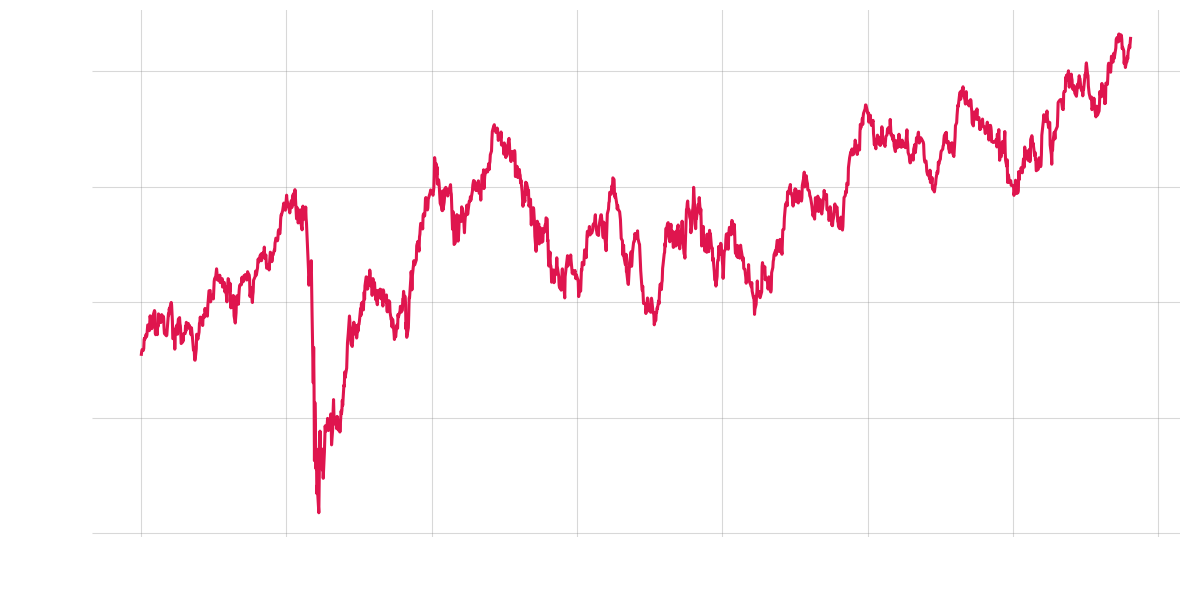

In [ ]:
import matplotlib.pyplot as plt
import yfinance as yf

# dados do IBOVESPA
ticker = "^BVSP"
start_date = "2019-01-01"
end_date = "2025-10-24"

df = yf.download(ticker, start=start_date, end=end_date)

# Cria o gráfico 
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], color="#DF154E", linewidth=2.2)


plt.xlabel("Data", color='white')
plt.ylabel("Fechamento (R$)", color='white')

# Remove fundo e bordas
plt.gca().set_facecolor("none")
plt.gcf().set_facecolor("none")
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tick_params(colors='white')
plt.grid(alpha=0.3, color='gray')
plt.tight_layout()
plt.show()


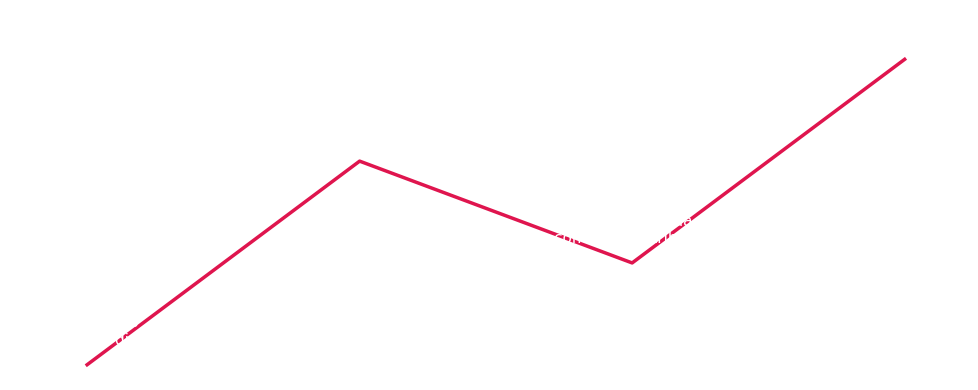

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))
plt.plot([1, 2, 3, 4], [2, 4, 3, 5], color="#DF154E", linewidth=2.5)
plt.text(1, 2.2, "Dados brutos\n(Fechamento diário)", fontsize=11, ha="center", color="white")
plt.text(2, 4.2, "Engenharia de Atributos\n(RSI, Médias, MACD...)", fontsize=11, ha="center", color="white")
plt.text(3, 3.2, "Base preparada\ncom novos atributos", fontsize=11, ha="center", color="white")
plt.text(4, 5.2, "Modelo preditivo\n(↑ ou ↓)", fontsize=11, ha="center", color="white")

plt.gca().set_facecolor("none")
plt.gcf().set_facecolor("none")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.xticks([])
plt.yticks([])
plt.grid(alpha=0.3, color="gray")
plt.tight_layout()
plt.show()


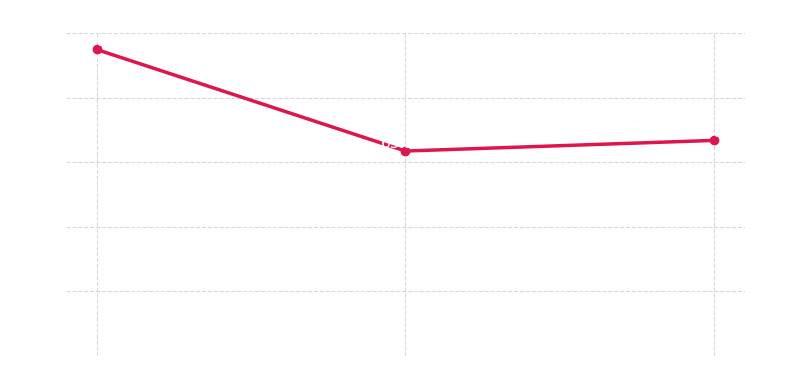

In [36]:
import matplotlib.pyplot as plt

# Dados
modelos = ["Regressão Logística", "Random Forest", "Gradient Boosting"]
acuracias = [95.0, 63.5, 66.8]  # em porcentagem

# Gráfico de linha
plt.figure(figsize=(8, 4))
plt.plot(modelos, acuracias, marker='o', color="#DF154E", linewidth=2.5)

# Adiciona os valores sobre os pontos
for i, v in enumerate(acuracias):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=11, color='white')

# Personalização visual
plt.title("Acurácia dos Modelos (%)", fontsize=14, fontweight="bold", color="white")
plt.ylabel("Acurácia (%)", color="white")
plt.ylim(0, 100)

plt.gca().set_facecolor("none")
plt.gcf().set_facecolor("none")

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.grid(alpha=0.3, color="gray", linestyle='--')
plt.tick_params(colors="white")

plt.tight_layout()
plt.show()


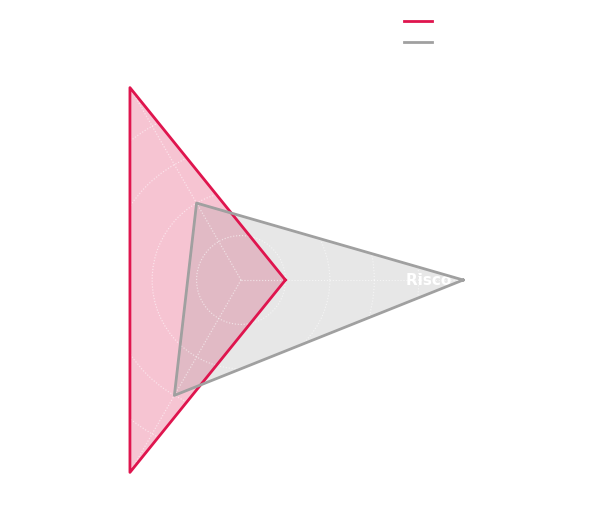

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Características comparadas
caracteristicas = ["Risco de Overfitting", "Interpretabilidade", "Estabilidade"]
modelos_simples = [1, 5, 5]
modelos_complexos = [5, 2, 3]

# Número de variáveis
N = len(caracteristicas)

# Ângulos do gráfico 
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

# Fechando o loop das pontas dos gráficos
valores_simples = modelos_simples + [modelos_simples[0]]
valores_complexos = modelos_complexos + [modelos_complexos[0]]

# Figura transparente
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True), facecolor='none')
ax.set_facecolor('none')

# Gráfico de radar
ax.plot(angles, valores_simples, color="#DF154E", linewidth=2, label="Modelos Simples 🧠")
ax.fill(angles, valores_simples, color="#DF154E", alpha=0.25)

ax.plot(angles, valores_complexos, color="#A0A0A0", linewidth=2, label="Modelos Complexos ⚙️")
ax.fill(angles, valores_complexos, color="#A0A0A0", alpha=0.25)

# Configurações visuais
ax.set_xticks(angles[:-1])
ax.set_xticklabels(caracteristicas, color="white", fontsize=11, fontweight="bold")
ax.set_yticklabels([])
ax.spines['polar'].set_visible(False)
ax.grid(color="white", linestyle="dotted", alpha=0.6)


# Legenda branca
leg = ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), frameon=False)
for text in leg.get_texts():
    text.set_color("white")

# Salvar sem fundo
plt.savefig("grafico_radar_tradeoff.png", dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()
